In [1]:
import pandas as pd
from itertools import product
from IPython.display import display
import ast
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from itertools import product
from tueplots import bundles
import seaborn as sns
from matplotlib.ticker import MaxNLocator


style = bundles.neurips2024(usetex=False)
style["font.size"] *= 1.2
style["legend.fontsize"] *= 1.2
style["axes.titlesize"] *= 1.2
style["xtick.labelsize"] *= 1.2
style["ytick.labelsize"] *= 1.2
print(style)
plt.rcParams.update(style)
results_folder = "results_cropped"

def process_results(df, saturation_threshold=0.95):
    # Find all columns that end with "informedness"
    informedness_cols = [col for col in df.columns if col.endswith("informedness")]

    # Informedness values are tuples (train, test)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for col in informedness_cols:
        df[col] = df[col].apply(ast.literal_eval)
        df_test[col] = df[col].apply(lambda x: x[1])
        df_train[col] = df[col].apply(lambda x: x[0])
    
    # For each row, find which column obtains maximum train value
    for classifier_type in "rbf", "lr":
        classifier_cols = filter(lambda x: classifier_type in x, informedness_cols)
        optimal_descriptors = df_train[classifier_cols].idxmax(axis=1)
        optimal_test_values = [df_test.loc[i][col] for i, col in enumerate(optimal_descriptors)]
        df[f"{classifier_type}_informedness"] = optimal_test_values

    df[informedness_cols] = df_test

    informedness_cols = informedness_cols + ["rbf_informedness", "lr_informedness"]

    is_saturated = df[informedness_cols] >= saturation_threshold
    saturation_points = {}
    for col in informedness_cols:
        arr = is_saturated[col].values
        remains_saturated = np.cumprod(arr[::-1], axis=0)[::-1].astype(int)
        saturation_points[col] = df["noise_level"][remains_saturated.argmax().min()] if remains_saturated.any() else 1.0

    return df, saturation_points

perturbations = ["edge_deletion", "edge_rewiring", "edge_swapping", "mixing", "edge_addition"]
datasets = ["planar", "lobster", "proteins", "sbm", "ego"]
all_saturation_points = defaultdict(dict)

all_dfs = defaultdict(dict)

for perturbation, dataset in product(perturbations, datasets):
    df = pd.read_csv(f"{results_folder}/perturbation_{dataset}_{perturbation}.csv")
    df, saturation_points = process_results(df)

    all_saturation_points[perturbation][dataset] = saturation_points["lr_informedness"]
    all_dfs[perturbation][dataset] = df


all_saturation_points = pd.DataFrame(all_saturation_points)
#all_saturation_points.to_csv("all_saturation_points.csv")
display(all_saturation_points)

{'text.usetex': False, 'font.serif': ['Times'], 'mathtext.fontset': 'stix', 'mathtext.rm': 'Times', 'mathtext.it': 'Times:italic', 'mathtext.bf': 'Times:bold', 'font.family': 'serif', 'figure.figsize': (5.5, 3.399186938124422), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 10.799999999999999, 'axes.labelsize': 9, 'legend.fontsize': 8.4, 'xtick.labelsize': 8.4, 'ytick.labelsize': 8.4, 'axes.titlesize': 10.799999999999999}


,edge_deletion,edge_rewiring,edge_swapping,mixing,edge_addition
planar,0.019182,0.017753,0.031833,0.950107,0.024793
lobster,1.000000,1.000000,1.000000,0.959902,1.000000
proteins,0.227630,0.064993,0.069993,1.000000,0.078359
sbm,0.252525,1.000000,1.000000,0.959596,0.116315
ego,0.119988,0.727273,1.000000,0.969697,0.359963


# Correlation Plots
Below, we plot the correlation of the different metrics with the noise level.

In [2]:
def to_descriptor_color(metric_name):
    colors = sns.color_palette("colorblind")
    descriptor_colors = {
        "orbit": colors[0],
        "degree": colors[1],
        "spectral": colors[2],
        "clustering": colors[3],
        "gin": colors[4],
    }
    for key, value in descriptor_colors.items():
        if key in metric_name:
            return value
    assert metric_name in ["lr_informedness", "rbf_informedness"]
    return "black"

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


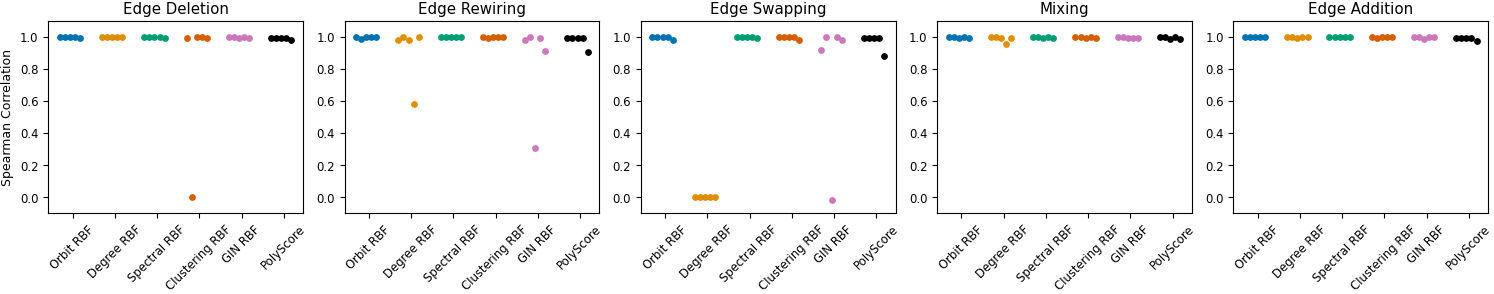

In [3]:
all_correlation_dfs = defaultdict(dict)

for perturbation, dataset in product(perturbations, datasets):
    all_correlation_dfs[perturbation][dataset] = all_dfs[perturbation][dataset].corr("spearman")

# Create a jitter plot
metrics_to_compare = OrderedDict([
    ("orbit_rbf", "Orbit RBF"),
    ("degree_rbf", "Degree RBF"),
    ("spectral_rbf", "Spectral RBF"),
    ("clustering_rbf", "Clustering RBF"),
    ("gin_rbf", "GIN RBF"),
    ("lr_informedness", "PolyScore"),
])

perturbations_to_plot = OrderedDict([
    ("edge_deletion", "Edge Deletion"), 
    ("edge_rewiring", "Edge Rewiring"), 
    ("edge_swapping", "Edge Swapping"), 
    ("mixing", "Mixing"), 
    ("edge_addition", "Edge Addition"
)])

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i, (perturbation, label) in enumerate(perturbations_to_plot.items()):
    if ax.ndim == 1:
        current_ax = ax[i]
    else:
        current_ax = ax[i // ax.shape[1]][i % ax.shape[1]]
    current_ax.set_xticks(range(len(metrics_to_compare)))
    current_ax.set_xticklabels(metrics_to_compare.values(), rotation=45)
    current_ax.set_ylim(-0.1, 1.1)
    current_ax.set_title(label)
    if i == 0:
        current_ax.set_ylabel("Spearman Correlation")

    for j, (metric, metric_label) in enumerate(metrics_to_compare.items()):
        all_x = []
        all_y = []
        for k, dataset in enumerate(datasets):
            correlation = all_correlation_dfs[perturbation][dataset][metric]["noise_level"]
            #x_offset = np.random.uniform(-0.3, 0.3)
            x_offset = k / len(datasets) * 0.6 - 0.3
            all_x.append(x_offset + j)
            all_y.append(correlation if np.isfinite(correlation) else 0)
        current_ax.scatter(all_x, all_y, label=metric_label, color=to_descriptor_color(metric), s=15)

plt.savefig("correlation_plots.pdf")

# Metrics vs Noise Level Plots

Now, we plot the metrics against the noise level. These plots are intended to compare the expressiveness of different descriptors. They will go in the appendix.

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


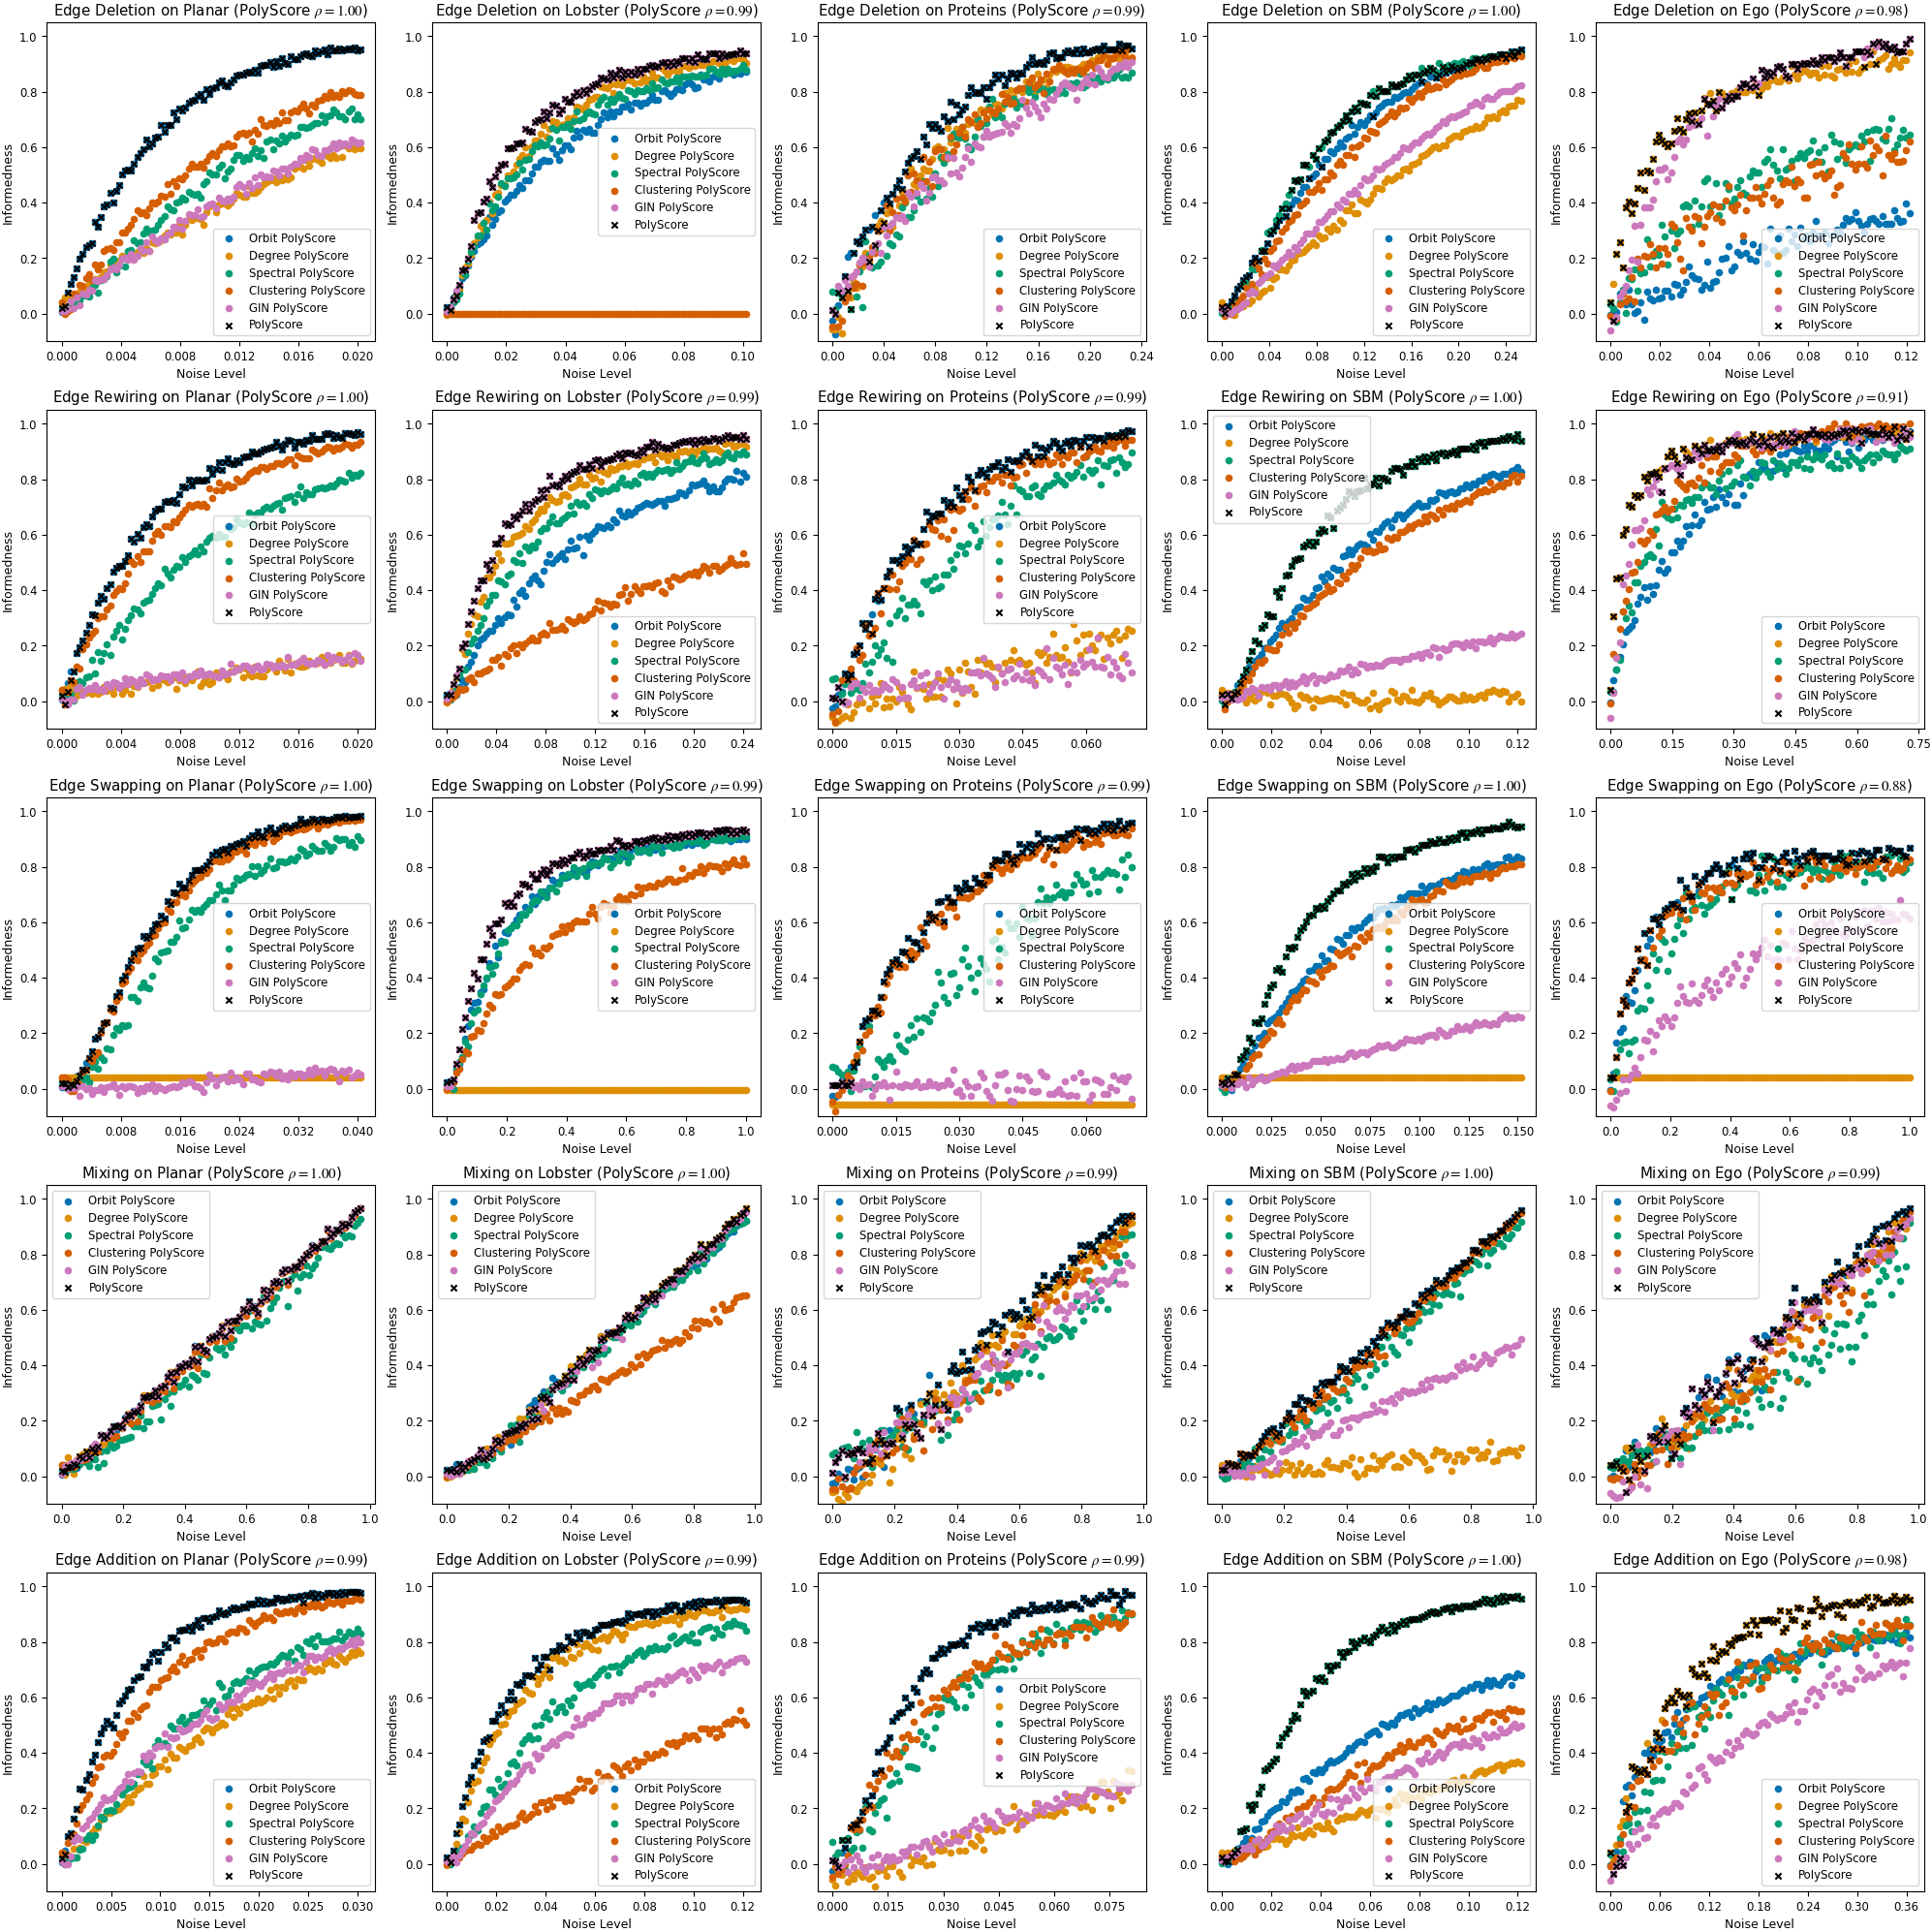

In [4]:
def plot_metrics_vs_noise_level(perturbations_to_plot, datasets_to_plot, metrics_to_plot, color_fn):
    fig, ax = plt.subplots(nrows=len(perturbations_to_plot), ncols=len(datasets_to_plot), figsize=(4 * len(datasets_to_plot), 4 * len(perturbations_to_plot)))

    for i, j in product(range(len(perturbations_to_plot)), range(len(datasets_to_plot))):
        current_ax = ax[i, j]
        current_ax.set_ylim(-0.1, 1.05)
        perturbation, perturbation_label = list(perturbations_to_plot.items())[i]
        dataset, dataset_label = list(datasets_to_plot.items())[j]
        for metric, (metric_label, marker) in metrics_to_plot.items():
            current_ax.xaxis.set_major_locator(MaxNLocator(7))
            current_ax.scatter(all_dfs[perturbation][dataset]["noise_level"], all_dfs[perturbation][dataset][metric], label=metric_label, marker=marker, color=color_fn(metric), s=20)
            current_ax.set_title(f"{perturbation_label} on {dataset_label} (PolyScore $\\rho = {all_correlation_dfs[perturbation][dataset]['lr_informedness']['noise_level']:.2f}$)")
            current_ax.set_xlabel("Noise Level")
            current_ax.set_ylabel("Informedness")
            current_ax.legend()
        
    return fig, ax



perturbations_to_plot = OrderedDict([
    ("edge_deletion", "Edge Deletion"), 
    ("edge_rewiring", "Edge Rewiring"), 
    ("edge_swapping", "Edge Swapping"), 
    ("mixing", "Mixing"), 
    ("edge_addition", "Edge Addition"
)])

datasets_to_plot = OrderedDict([
    ("planar", "Planar"),
    ("lobster", "Lobster"),
    ("proteins", "Proteins"),
    ("sbm", "SBM"),
    ("ego", "Ego"),
])

metrics_to_plot = OrderedDict([
    ("orbit_lr_informedness", ("Orbit PolyScore", "o")),
    ("degree_lr_informedness", ("Degree PolyScore", "o")),
    ("spectral_lr_informedness", ("Spectral PolyScore", "o")),
    ("clustering_lr_informedness", ("Clustering PolyScore", "o")),
    ("gin_lr_informedness", ("GIN PolyScore", "o")),
    ("lr_informedness", ("PolyScore", "x")),
])

fig, ax = plot_metrics_vs_noise_level(perturbations_to_plot, datasets_to_plot, metrics_to_plot, color_fn=to_descriptor_color)
fig.savefig("metrics_vs_noise_level.pdf")

Next, we compare linear regression against the RBF kernel classifier

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


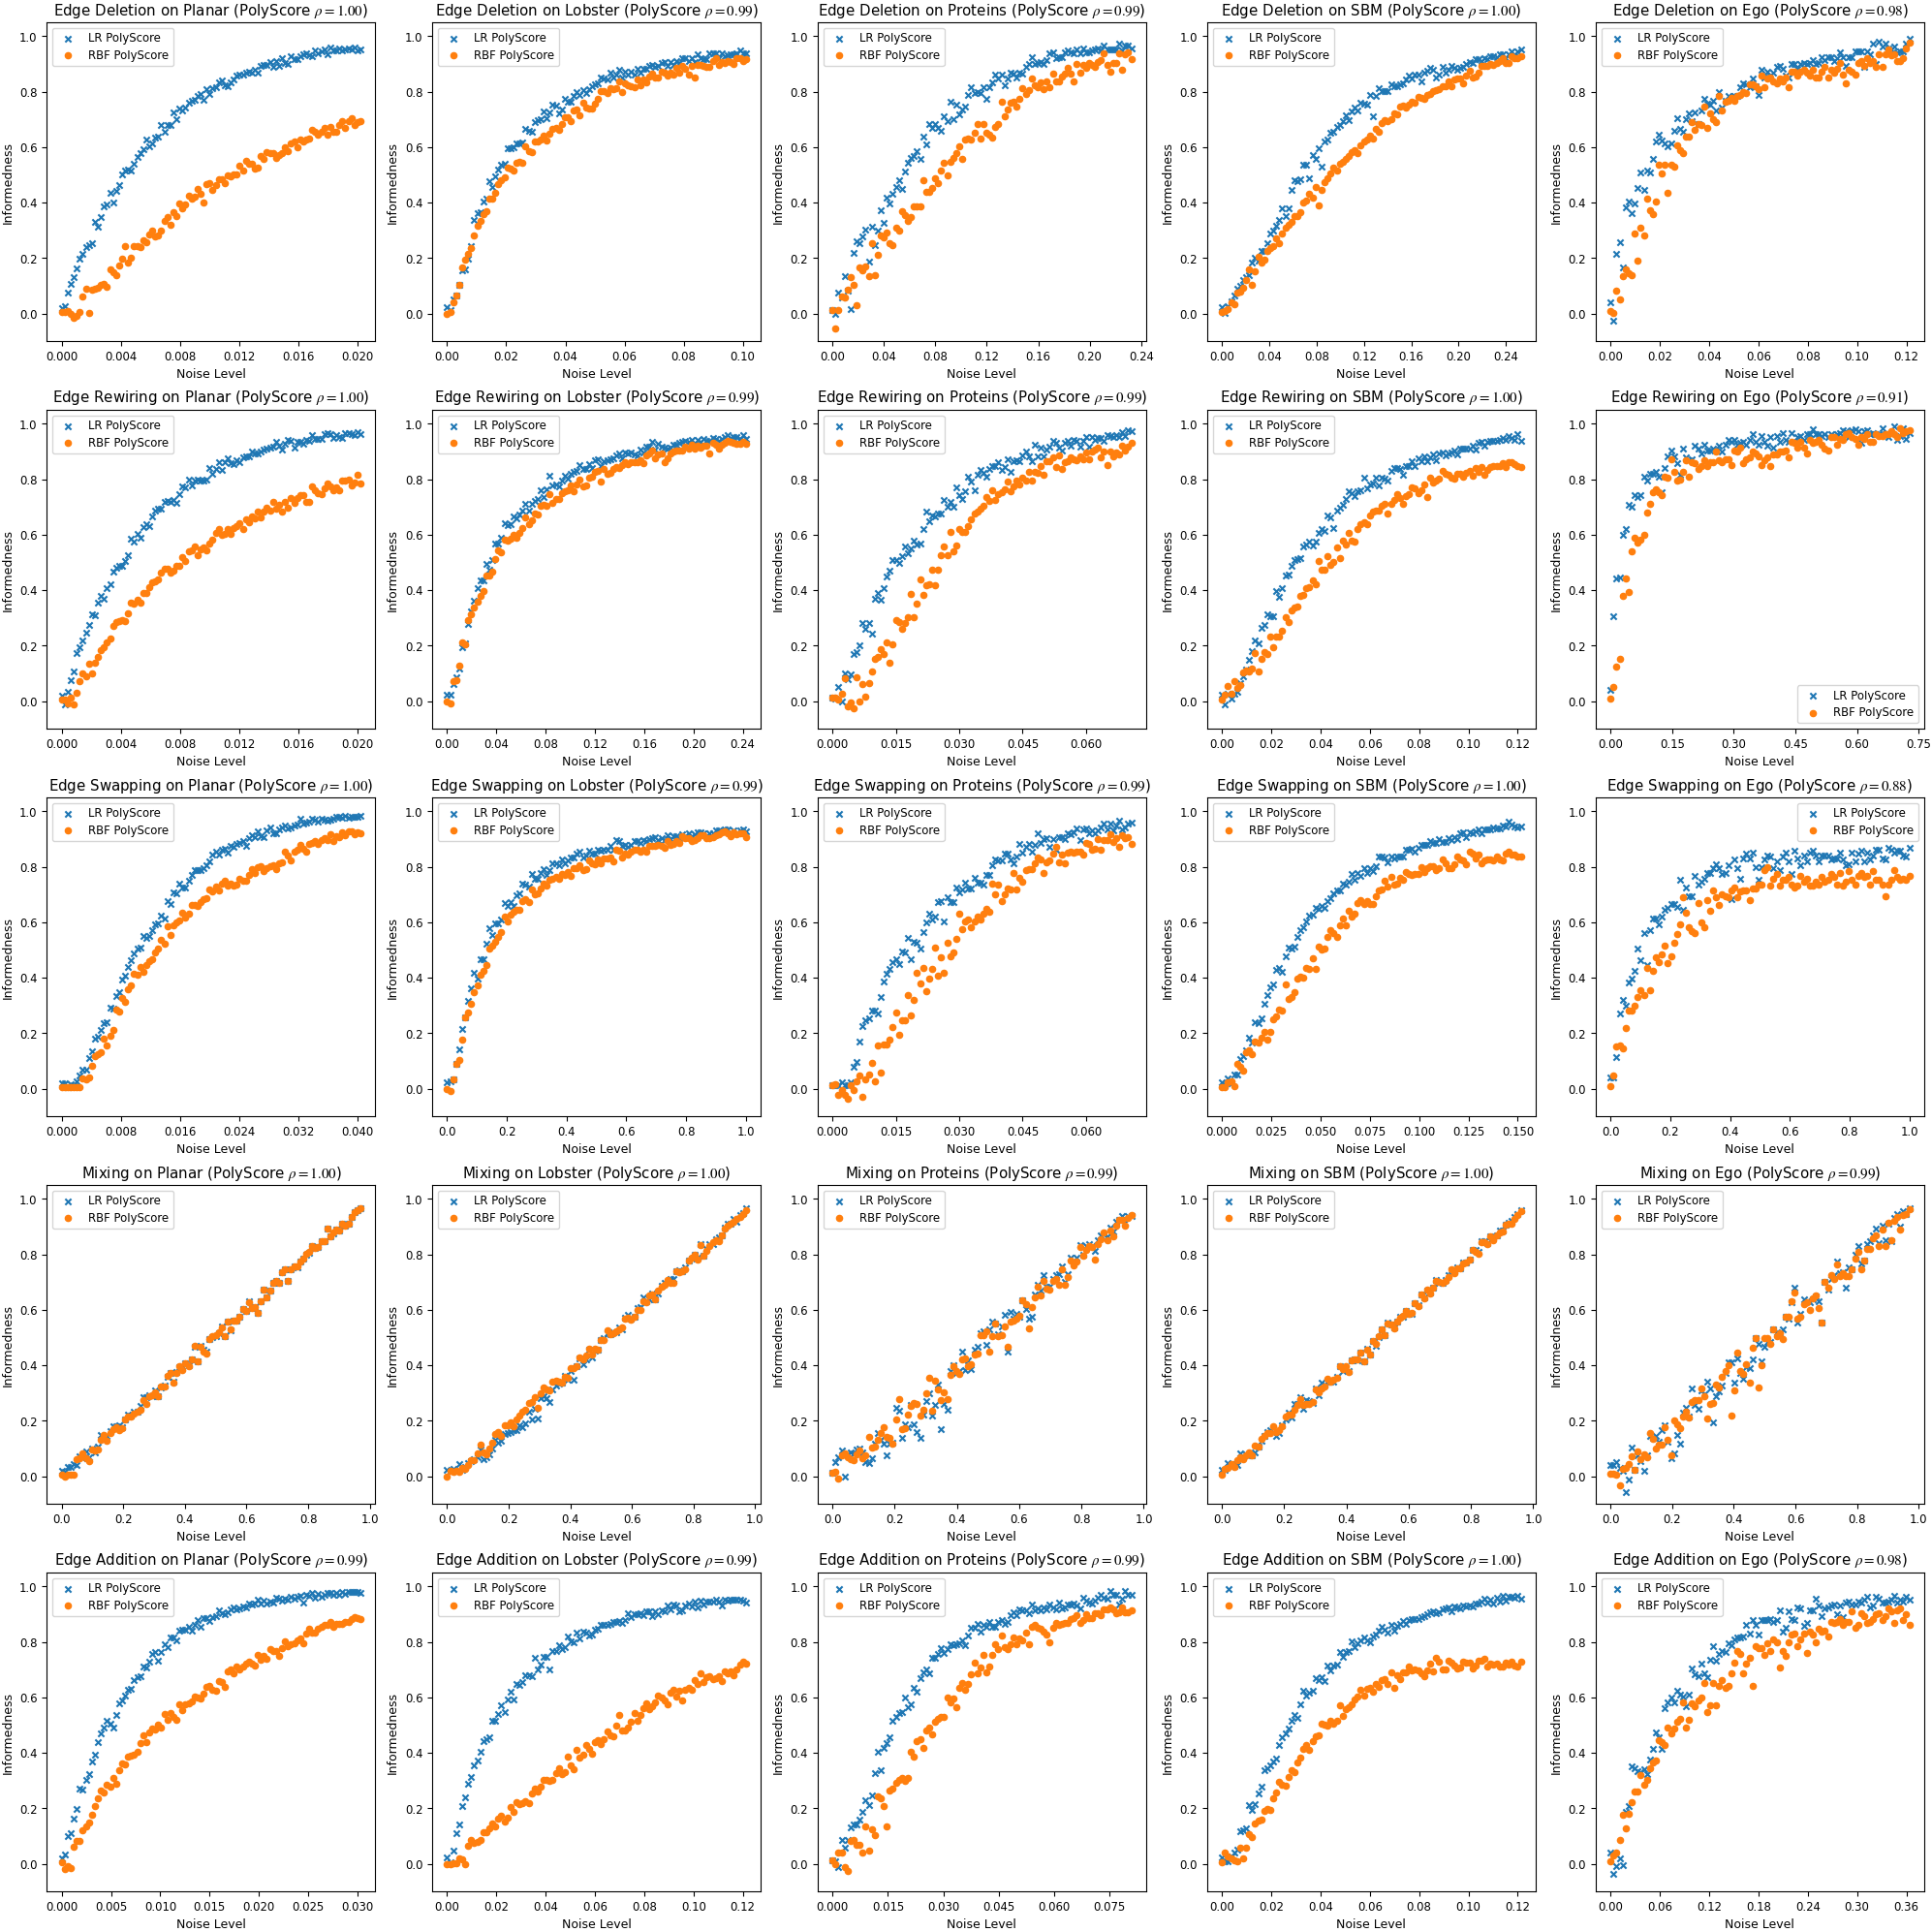

In [5]:
perturbations_to_plot = OrderedDict([
    ("edge_deletion", "Edge Deletion"), 
    ("edge_rewiring", "Edge Rewiring"), 
    ("edge_swapping", "Edge Swapping"), 
    ("mixing", "Mixing"), 
    ("edge_addition", "Edge Addition"
)])

datasets_to_plot = OrderedDict([
    ("planar", "Planar"),
    ("lobster", "Lobster"),
    ("proteins", "Proteins"),
    ("sbm", "SBM"),
    ("ego", "Ego"),
])

metrics_to_plot = OrderedDict([
    ("lr_informedness", ("LR PolyScore", "x")),
    ("rbf_informedness", ("RBF PolyScore", "o"))
])

fig, ax = plot_metrics_vs_noise_level(perturbations_to_plot, datasets_to_plot, metrics_to_plot, lambda x: None)
fig.savefig("rbf_vs_lr.pdf")
